# Simulating
This can be done many differet ways from statistical models informed based on the team/player performance or simple models which focus on specific attributes or are random simulators.  

---
To get started, a simple model will be leveraged to simulate a football match. One in which goals occur completely at random during the match.

In [1]:
import numpy as np
import numpy.random as rnd
import pandas as pd
import time
import pylab as plt
import sketch

### Setting parameters for the simplified model
Set up the basic scoring rates for football and other contoling aspects of a game. 

In [2]:
# Length of match
match_minutes = 90
# Average goals per match
goals_per_match = 2.79
# Probability of a goal per minute
prob_per_minute = np.array(goals_per_match/match_minutes)
print(f'The probability of a goal per minute is {prob_per_minute:.5f}\n' )

The probability of a goal per minute is 0.03100



### Simulating a single game
To simulate a single game, Goals go in with the same probability every minute. Run the simulation below 10 times. How many times were there 3 goals in a match?

In [3]:
def sim_match(match_minutes:int=90, show:bool=False, ):
    '''Simulate a soccer match without stipulating team details'''
    
    #Count of the number of goals
    goals=0

    for minute in range(match_minutes):
        r=rnd.rand(1,1) # Generate a random number between 0 and 1.
        
        # Prints an X when there is a goal and a zero otherwise.
        if (r < prob_per_minute): 
            if show:
                print('X', end = ' ') #Goal - if the random number is less than the goal probability.
                time.sleep(0.3)  #Longer pause
            goals+=1
            
        else:
            if show:
                print('o', end = ' ')
                time.sleep(0.1)  #Short pause

    if show:
        print('Final whistle. \n \nThere were ' + str(goals) + ' goals.')
    return goals

In [4]:
sim_match(show=True)

o X 

o o o o o o o o o o o o o o o o o o o X o o o o o o o o o o o X o o o X o o o o o o o o o o o o o o o o o o X o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o o Final whistle. 
 
There were 5 goals.


5

           Goals
count  10.000000
mean    3.000000
std     1.414214
min     1.000000
25%     2.000000
50%     3.500000
75%     4.000000
max     5.000000


Text(0.5, 1.0, 'Goals per match simulated')

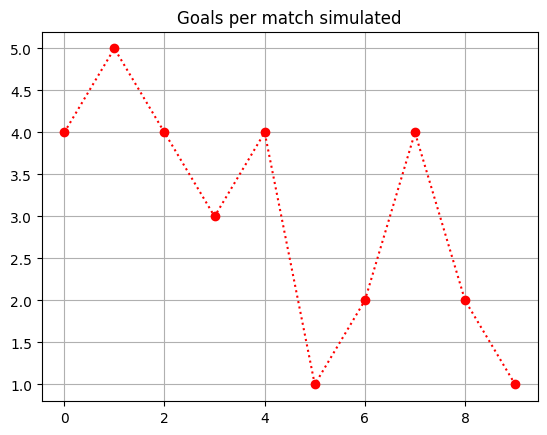

In [5]:
G=pd.DataFrame([sim_match() for i in range(10)], columns=['Goals'])

print(G.describe())
fig, ax = plt.subplots()
G.Goals.plot(style='r:o', ax=ax)
ax.grid(True)
ax.set_title('Goals per match simulated')

### Simulating goals over a season
Now there is a need to shift to an entire season. This requires 380 games to be played accounting for the Fall and Spring of a professional campaign.  To accomplish this the code for the single match is extended and modified to simulate the games and store the results in an array.

1. Define new simulateMatch function 
2. Loop over 380 matches
3. Store the number of goals for each match in an array 
4. Create a histogram of the number of goals

In [6]:
def simulateMatch(n:int=90, p:float=0.03100):
    '''
    Simulate a football match
    
    n - number of time units
    p - probability per time unit of a goal
    display_match == True then display simulation output for match.

    Return array with Count of the number of goals per match across the season'''
    
    goals = 0
    for minute in range(n): 
        r = rnd.rand(1, 1) # Generate a random number between 0 and 1.
        if (r < p):
            goals += 1 # Incrament Goal - if the random number is less than the goal probability.
            
    return goals

In [7]:
# Choose a Number of matches
num_matches = 380

# Loop over all the matches return goals storing the value in initialized numpy array.
goals = np.zeros(num_matches)
for i in range(num_matches):
    goals[i] = simulateMatch(match_minutes, prob_per_minute) # stores value at match index for range

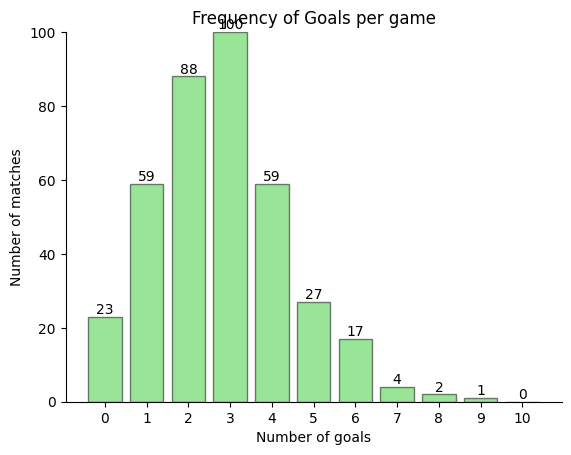

In [8]:
# Create a histogram

fig, ax = plt.subplots(num=1)

histogram_range = np.arange(-0.5, 10.51, 1)
histogram_goals = np.histogram(goals, histogram_range)

p = ax.bar(histogram_goals[1][:-1] + 0.5, histogram_goals[0], color='limegreen', edgecolor='black', linestyle='-', alpha=0.5)
ax.set_ylim(0, 100)
ax.bar_label(p)
ax.spines[['top','right']].set_visible(False)
ax.set_xticks(np.arange(0, 11, step=1))
ax.set_yticks(np.arange(0, 101, step=20))
ax.set_xlabel('Number of goals')
ax.set_ylabel('Number of matches')
ax.set_title('Frequency of Goals per game')
plt.show()

### Simulating results
Use a Poisson regression to fit a model to the Premier League and then we use the estimated values to simulate results between two teams.

This code is adapted from this [artical](https://dashee87.github.io/football/python/predicting-football-results-with-statistical-modelling/)

In [9]:
# importing the tools required for the Poisson regression model
import statsmodels.api as sm
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
import seaborn
from scipy.stats import poisson,skellam

#### Import data
Data taken from football-data.co.uk

In [10]:
epl = pd.read_csv("https://www.football-data.co.uk/mmz4281/2122/E0.csv")
ep = (epl[['HomeTeam','AwayTeam','FTHG','FTAG']]
      .rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
     )

In [11]:
epl = (epl
       .rename(columns={'FTHG': 'HomeGoals', 'FTAG': 'AwayGoals'})
       [:-10]
      )
       
epl.mean(numeric_only=True)

HomeGoals     1.491892
AwayGoals     1.297297
HTHG          0.686486
HTAG          0.586486
HS           13.764865
               ...    
PCAHA         1.976486
MaxCAHH       2.019946
MaxCAHA       2.054649
AvgCAHH       1.925973
AvgCAHA       1.959514
Length: 98, dtype: float64

### Perform the regression
In the fit, include a parameter for home advantage. Team and opponent are fixed effects.

In [12]:
goal_model_data = (pd.concat([epl[['HomeTeam','AwayTeam','HomeGoals']]
                              .assign(home=1)
                              .rename(columns={'HomeTeam':'team', 'AwayTeam':'opponent','HomeGoals':'goals'}),
                             epl[['AwayTeam','HomeTeam','AwayGoals']]
                              .assign(home=0)
                              .rename(columns={'AwayTeam':'team', 'HomeTeam':'opponent','AwayGoals':'goals'})])
                  )

In [13]:
goal_model_data.head(3)

,team,opponent,goals,home
0,Brentford,Arsenal,2,1
1,Man United,Leeds,5,1
2,Burnley,Brighton,1,1


In [14]:
poisson_model = smf.glm(formula="goals ~ home + team + opponent", data=goal_model_data,
                        family=sm.families.Poisson()).fit()
poisson_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                  goals   No. Observations:                  740
Model:                            GLM   Df Residuals:                      700
Model Family:                 Poisson   Df Model:                           39
Link Function:                    Log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -1043.1
Date:                Mon, 16 Oct 2023   Deviance:                       776.72
Time:                        20:26:26   Pearson chi2:                     681.
No. Iterations:                     5   Pseudo R-squ. (CS):             0.2498
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------------
Intercept                      0.2470      0.203      1.214      0.225      -0.152       0.646
team[T.Aston Villa]           -0.1298      0.195     -0.666      0.506      -0.512       0.252
team[T.Brentford]             -0.1589      0.198     -0.802      0.423      -0.547       0.230
team[T.Brighton]              -0.3735      0.209     -1.788      0.074      -0.783       0.036
team[T.Burnley]               -0.5263      0.220     -2.395      0.017      -0.957      -0.096
team[T.Chelsea]                0.2714      0.177      1.529      0.126      -0.077       0.619
team[T.Crystal Palace]        -0.1370      0.196     -0.699      0.484      -0.521       0.247
team[T.Everton]               -0.2847      0.204     -1.394      0.163      -0.685       0.116
team[T.Leeds]                 -0.3127      0.207     -1.507      0.132      -0.719       0.094
team[T.Leicester]              0.0481      0.188      0.256      0.798      -0.320       0.416
team[T.Liverpool]              0.4522      0.170      2.657      0.008       0.119       0.786
team[T.Man City]               0.5115      0.168      3.036      0.002       0.181       0.842
team[T.Man United]             0.0156      0.189      0.083      0.934      -0.354       0.385
team[T.Newcastle]             -0.2841      0.204     -1.389      0.165      -0.685       0.117
team[T.Norwich]               -0.8697      0.248     -3.507      0.000      -1.356      -0.384
team[T.Southampton]           -0.2770      0.205     -1.354      0.176      -0.678       0.124
team[T.Tottenham]              0.1294      0.183      0.706      0.480      -0.230       0.489
team[T.Watford]               -0.5181      0.220     -2.357      0.018      -0.949      -0.087
team[T.West Ham]               0.0398      0.187      0.213      0.831      -0.327       0.406
team[T.Wolves]                -0.4429      0.212     -2.088      0.037      -0.859      -0.027
opponent[T.Aston Villa]        0.1071      0.203      0.529      0.597      -0.290       0.504
opponent[T.Brentford]          0.1297      0.200      0.649      0.516      -0.262       0.521
opponent[T.Brighton]          -0.0994      0.211     -0.470      0.638      -0.514       0.315
opponent[T.Burnley]            0.0579      0.202      0.286      0.775      -0.339       0.455
opponent[T.Chelsea]           -0.3702      0.230     -1.613      0.107      -0.820       0.080
opponent[T.Crystal Palace]    -0.0219      0.208     -0.105      0.916      -0.429       0.385
opponent[T.Everton]            0.2573      0.194      1.325      0.185      -0.123       0.638
opponent[T.Leeds]              0.4973      0.185      2.688      0.007       0.135       0.860
opponent[T.Leicester]          0.2134      0.197      1.085      0.278      -0.172       0.599
opponent[T.Liverpool]         -0.6001      

### Simulating a game
Simulate a match between Manchester City and Arsenal.  This will leverage the poission model to simulate a score rate for each team, and the outcome of a match between the two.  This will be followed by a simulation of the probability of all likely score lines between the two teams.

In [15]:
# Set teams
home_team='Tottenham'
away_team='Arsenal'

In [16]:
# Predict for Arsenal vs. Tottenham home and away series
home_score_rate=poisson_model.predict(pd.DataFrame(data={'team': home_team, 'opponent': away_team,
                                       'home':1},index=[1]))
away_score_rate=poisson_model.predict(pd.DataFrame(data={'team': away_team, 'opponent': home_team,
                                       'home':0},index=[1]))
print(f'{home_team} against {away_team} expect to score: ' + str(home_score_rate))
print(f'{away_team} against {home_team} expect to score: ' + str(away_score_rate))

Tottenham against Arsenal expect to score: 1    1.693137
dtype: float64
Arsenal against Tottenham expect to score: 1    1.090481
dtype: float64


In [17]:
# Simulate a direct result
home_goals=np.random.poisson(home_score_rate)
away_goals=np.random.poisson(away_score_rate)
print(home_team + ': ' + str(home_goals[0]))
print(away_team + ': '  + str(away_goals[0]))

Tottenham: 5
Arsenal: 1


>**NOTE**: Sometimes big match ups do not result in goals

### Two-dimensional histogram of scores
This provides the probability of multiple score lines between the two teams in question, home and away.  The simulation is run with a max goal limit set to a default of 10 which limits outcomes, but this will be defined at the time of simulation.  

In [18]:
# Function to caluclate the goals for the match.
def simulate_match(foot_model, homeTeam, awayTeam, max_goals=10):
    '''Function which determines average goals for the home and away teams, and then uses the average
    to simulate the outcome of a game
    foot_model = predictive model developed ahead of simulation
    homeTeam/awayTeam = string entry for team names
    max_goals = integer goal limit for simulation'''
    home_goals_avg = foot_model.predict(pd.DataFrame(data={'team': homeTeam,'opponent': awayTeam, 'home': 1},
                                                     index=[1])).values[0]
    away_goals_avg = foot_model.predict(pd.DataFrame(data={'team': awayTeam,'opponent': homeTeam, 'home': 0},
                                                     index=[1])).values[0]
    team_pred = [[poisson.pmf(i, team_avg) for i in range(0, max_goals + 1)] for team_avg in
                 [home_goals_avg, away_goals_avg]]
    return (np.outer(np.array(team_pred[0]), np.array(team_pred[1])))

In [19]:
#Fill in the matrix
max_goals=5
score_matrix=simulate_match(poisson_model, home_team, away_team,max_goals)

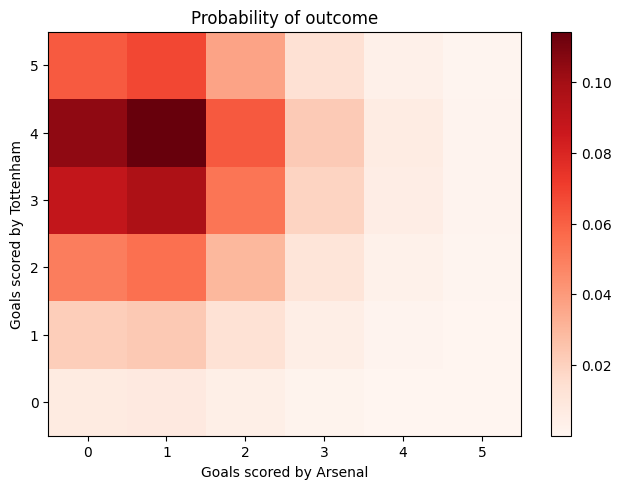

In [20]:
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
pos=ax.imshow(score_matrix, extent=[-0.5,max_goals+0.5,-0.5,max_goals+0.5], aspect='auto',cmap=plt.cm.Reds)
fig.colorbar(pos, ax=ax)
ax.set_title('Probability of outcome')
plt.xlim((-0.5,5.5))
plt.ylim((-0.5,5.5))
plt.tight_layout()
ax.set_xlabel('Goals scored by ' + away_team)
ax.set_ylabel('Goals scored by ' + home_team)
plt.show()

# Home, draw, away probabilities
homewin=np.sum(np.tril(score_matrix, -1))
draw=np.sum(np.diag(score_matrix))
awaywin=np.sum(np.triu(score_matrix, 1))

### Statistical modelling
In this section a variety of methods is considered for evaluating the degree to which passing/possession lead to goals being scroed, and how to identify the strongest areas on the pitch for a team.  These are two very specific methodologies being considered; Ball movement vs positioning.  Each has its place to improve the team's chances for success.

In [21]:
#importing necessary libraries
from mplsoccer import Sbopen, Pitch
import statsmodels.api as sm
import statsmodels.formula.api as smf
from matplotlib import colors

#open data from WWC 2019
parser = Sbopen()
df_match = parser.match(competition_id=72, season_id=30)

In [22]:
df_match.head(3)

,match_id,match_date,kick_off,home_score,away_score,match_status,match_status_360,last_updated,last_updated_360,match_week,...,competition_stage_id,competition_stage_name,stadium_id,stadium_name,stadium_country_id,stadium_country_name,referee_id,referee_name,referee_country_id,referee_country_name
0,22949,2019-06-12,2019-06-12 18:00:00,1,0,available,scheduled,2023-07-24 21:46:41.279089,2021-06-13 16:17:31.694,2,...,1,Regular Season,231,Stade du Hainaut,78,France,374.0,Kateryna Monzul,238.0,Ukraine
1,22943,2019-06-11,2019-06-11 21:00:00,13,0,available,scheduled,2023-07-24 21:45:44.511885,2021-06-13 16:17:31.694,1,...,1,Regular Season,232,Stade Auguste-Delaune II,78,France,NaN,NaN,NaN,NaN
2,22944,2019-06-11,2019-06-11 18:00:00,0,2,available,scheduled,2023-07-25 05:54:25.449812,2021-06-13 16:17:31.694,1,...,1,Regular Season,166,Roazhon Park,78,France,1638.0,Lucila Venegas Montes,147.0,Mexico


In [23]:
df_match.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52 entries, 0 to 51
Data columns (total 52 columns):
 #   Column                           Non-Null Count  Dtype         
---  ------                           --------------  -----         
 0   match_id                         52 non-null     int64         
 1   match_date                       52 non-null     datetime64[ns]
 2   kick_off                         52 non-null     datetime64[ns]
 3   home_score                       52 non-null     int64         
 4   away_score                       52 non-null     int64         
 5   match_status                     52 non-null     object        
 6   match_status_360                 52 non-null     object        
 7   last_updated                     52 non-null     datetime64[ns]
 8   last_updated_360                 52 non-null     datetime64[ns]
 9   match_week                       52 non-null     int64         
 10  competition_id                   52 non-null     int64         


### Data Prep
Two different dataframes are required for the analysis. 
- **passshot_df:** This dataframe will keep information about team performance in every game they played - index of a game, name of a team, number of shots, number of goals and number of danger passes by this team (see Danger passes). 
- **danger_passes_df:** Dataframe of all danger passes during the tournament. 

In [24]:
# get team names
teams = df_match["home_team_name"].unique()

# get indicies of all games
match_ids = df_match["match_id"]

In [25]:
# Initialize empty dataframes
# passshot_df = pd.DataFrame()
# danger_passes_df = pd.DataFrame()

## REFACTOR CODE

In [26]:
def get_season(comp_id: int = 72, season_id: int = 30):
    '''Get games from a season through mplsoccer parser method.
    
    inputs: comp_id from StatsBomb, season_id from Statsbomb
    returns: dataframe of season results'''
    parser = Sbopen()
    df_match_results = parser.match(comp_id, season_id)
    return df_match_results

In [27]:
def get_match_ids(df_season):
    '''Returns all match ids for a season in a list.
    input = Dataframe of a season of games
    returns = List of match ids from Statsbomb'''
    return df_season.match_id.to_list()

In [28]:
def get_match_event_data(match_idx):
    '''Extract event data for match in season.

    input: match_idx = index value from season dataframe
    returns: dataframe of match event data'''
    # open match event data
    df_match_events = parser.event(match_idx)[0]
    # get home and away team
    return df_match_events

In [29]:
def get_match_passshot_dangerpass(season_df):
    '''Create dataframe for passshot_df and danger_passes_df from season data'
    
    input = get_season function call
    return = dataframe of passes leading to shots and danger passes across a season'''
    # initialize empty frames for data
    passshot_df = pd.DataFrame()
    danger_passes_df = pd.DataFrame()
    matches = get_match_ids(season_df)
    
    for match in matches:
        # extract match event data
        match_events =  get_match_event_data(match)
        
        # identify home and away team
        home_team = season_df.loc[lambda df:df.match_id == match]["home_team_name"].iloc[0]
        away_team = season_df.loc[lambda df:df.match_id == match]["away_team_name"].iloc[0]
        
        for team in [home_team, away_team]:
            # declare count variables to sum shots, passes and danger passes from both halves
            shots = 0
            passes = 0
            danger_passes = 0
            
            #for both periods
            for period in [1, 2]:
                # passes
                mask_pass = ((match_events.team_name == team) & (match_events.type_name == "Pass") & (match_events.outcome_name.isnull()) 
                             & (match_events.period == period) & (match_events.sub_type_name.isnull()))
                pass_df = match_events.loc[mask_pass]
                
                # A dataframe of shots ## Find passes within 15 seconds of a shot, exclude corners.
                shot_window = 15
                mask_shot = (match_events.team_name == team) & (match_events.type_name == "Shot") & (match_events.period == period)
                shot_df = match_events.loc[mask_shot, ["minute", "second"]]
                shot_times = shot_df['minute']*60+shot_df['second'] # convert time to seconds
                

                # find start of the window ## add condition to avoid negative shot starts
                shot_start = shot_times - shot_window
                shot_start = shot_start.apply(lambda i: i if i>0 else (period-1)*45) 
                pass_times = pass_df['minute']*60+pass_df['second']
                
                # check if pass is in any of the windows for this half
                pass_to_shot = pass_times.apply(lambda x: True in ((shot_start < x) & (x < shot_times)).unique())
                danger_passes_period = pass_df.loc[pass_to_shot]

                # will need later all danger passes
                danger_passes_df = pd.concat([danger_passes_df, danger_passes_period], ignore_index = True)

                # adding number of passes, shots and danger passes from a game
                passes += len(pass_df)
                shots += len(shot_df)
                danger_passes += len(danger_passes_period)
            #getting number of goals by the team from the game
            if team == home_team:
                goals = season_df.loc[lambda df:df.match_id == match]["home_score"].iloc[0]
            else:
                goals = season_df.loc[lambda df:df.match_id == match]["away_score"].iloc[0]
            #appending passshot dataframe
            match_info_df = pd.DataFrame({
                        "Team": [team],
                        "Passes": [passes],
                        "Shots": [shots],
                        "Goals": [goals],
                        "Danger Passes": [danger_passes]
                        })
            passshot_df = pd.concat([passshot_df, match_info_df])
    return passshot_df, danger_passes_df

In [30]:
passshot_df, danger_passes_df = get_match_passshot_dangerpass(season_df=get_season())

In [31]:
passshot_df.head()

,Team,Passes,Shots,Goals,Danger Passes
0,Germany Women's,156,13,1,26
0,Spain Women's,343,17,0,24
0,United States Women's,494,39,13,78
0,Thailand Women's,93,2,0,10
0,Chile Women's,109,5,0,9


### Plotting the Data
Often one of the most effective ways to see hidden truths in the data.  To investigate if there is any relation between number of passes and number of shots by a team in a game conduct a scatter plot of the data with the two fields of interest (passes and shots). In addition, highlight USA Women’s team  and Spain's performance in these areas.  

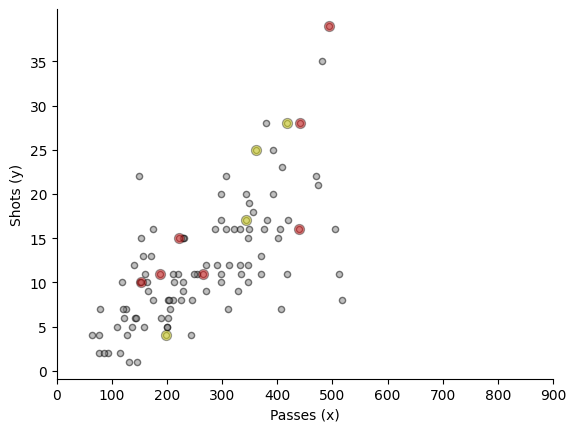

In [32]:
fig, ax = plt.subplots()
# plot all games
ax.scatter(passshot_df.Passes,passshot_df.Shots, color='grey', s=20, alpha=0.5, edgecolor='k')
# choose only USA games and plot them red
usa_df  = passshot_df.loc[passshot_df["Team"] == "United States Women's"]
ax.scatter(usa_df.Passes, usa_df.Shots, s=50, color='red', alpha=0.4, edgecolor='k')
# choose only England games and plot them red
spain_df  = passshot_df.loc[passshot_df["Team"] == "Spain Women's"]
ax.scatter(spain_df.Passes, spain_df.Shots, s=50, color='yellow', alpha=0.4, edgecolor='k')

# make plot details
ax.spines[['top','right']].set_visible(False)
ax.set_xticks(np.arange(0,1000,step=100))
ax.set_yticks(np.arange(0,40,step=5))
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Shots (y)')
plt.show()

### Fitting linear regression
To investigate the linear relationship between number of passes and number of shots, fit the linear regression using statsmodels library. Print out the summary of the model to make conclusions and plot the line on the previously plotted observations to see it with the data.

In [33]:

# changing datatype for smf
passshot_df = (passshot_df
 .assign(Shots = lambda df_: pd.to_numeric(df_.Shots),
         Passes = lambda df_: pd.to_numeric(df_.Passes),
         Goals = lambda df_: pd.to_numeric(df_.Goals))
)

In [34]:

# fit the model
model_fit=smf.ols(formula='Shots ~ Passes', data=passshot_df[['Shots','Passes']]).fit()
# print summary
print(model_fit.summary())


                            OLS Regression Results                            
Dep. Variable:                  Shots   R-squared:                       0.466
Model:                            OLS   Adj. R-squared:                  0.461
Method:                 Least Squares   F-statistic:                     88.98
Date:                Mon, 16 Oct 2023   Prob (F-statistic):           1.46e-15
Time:                        20:27:41   Log-Likelihood:                -318.20
No. Observations:                 104   AIC:                             640.4
Df Residuals:                     102   BIC:                             645.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      1.3098      1.268      1.033      0.3

In [35]:
# get coefficients
b = model_fit.params
# create x,y point values from the model for  aline line
x = np.arange(0, 1000, step=0.5)
y = b[0] + b[1]*x

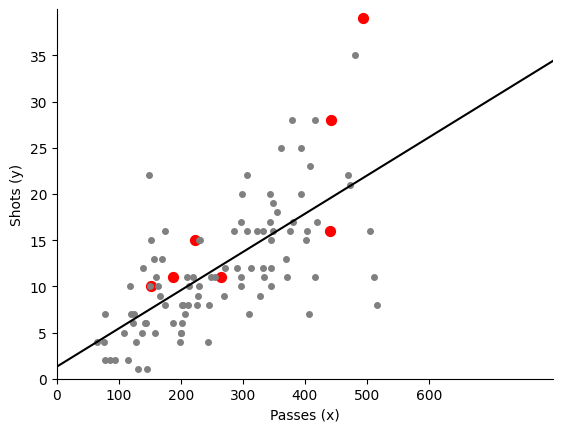

In [36]:
# repeat plotting points for
fig,ax=plt.subplots()
# plot all games
ax.plot('Passes','Shots', data=passshot_df.query('~Team.str.contains("United States")'), linestyle='none', markersize=4, marker='o', color='grey')
# choose only USA games and plot them red
usa_df  = passshot_df.loc[passshot_df["Team"] == "United States Women's"]
ax.scatter(usa_df.Passes, usa_df.Shots, s=50, color='red', alpha=1)

# make legend
ax.spines[['top','right']].set_visible(False)
ax.set_xticks(np.arange(0,700,step=100))
ax.set_yticks(np.arange(0,40,step=5))
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Shots (y)')

# make plot details
ax.plot(x, y, linestyle='-', color='black')
# make legend
ax.set_ylim(0,40)
ax.set_xlim(0,800)
plt.show()



### Fitting Poisson regression
To investigate the relationship between number of passes and number of goals, fit the Poisson regression using the statsmodels library. It is better to use Poisson regression since goals are infrequent versus passes. Again print out the summary of the model to make conclusions and plot the line on the previously plotted observations.

In [37]:
# fit the model
poisson_model = smf.glm(formula="Goals ~ Passes", data=passshot_df,
                    family=sm.families.Poisson()).fit()
# print summary
poisson_model.summary()
# get coefficients
b = poisson_model.params
# create model line
x = np.arange(0, 1000, step=0.5)
y = np.exp(b[0] + b[1]*x)


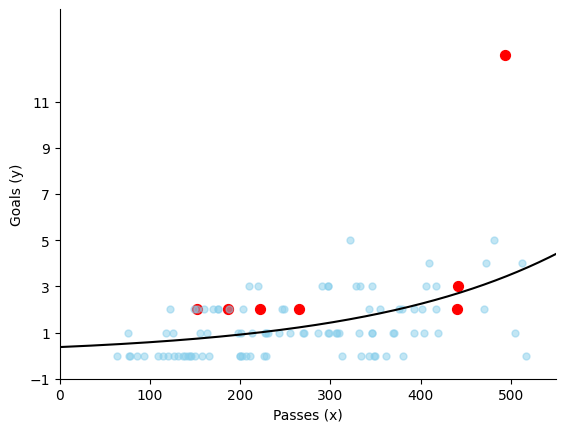

In [38]:
fig,ax=plt.subplots()
# plot all games
ax.plot('Passes','Goals', data=passshot_df.query('~Team.str.contains("United States")'), 
        linestyle='none', markersize=5, marker='o', color='skyblue', alpha=0.5)
# choose only USA games and plot them red
usa_df  = passshot_df.loc[passshot_df["Team"] == "United States Women's"]
ax.scatter(usa_df.Passes, usa_df.Goals, s=50, color='red', alpha=1)
# make legend
ax.set_xticks(np.arange(0,700,step=100))
ax.set_yticks(np.arange(-1,13,step=2))
ax.set_xlabel('Passes (x)')
ax.set_ylabel('Goals (y)')

# model plot
ax.plot(x, y, linestyle='-', color='black')
# make legend
ax.set_ylim(-1,15)
ax.set_xlim(0,550)
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.show()

### Comparative heatmaps
To find out which team outperformed and underperformed when it comes to the number of danger passes from different zones draw 24 pitches, one for each team that played in WWC 2019. Then, for each team, calculate the number of passes in each bin and normalize it by number of games by this team. As the next step, calculate average number of danger passes per zone throughout the tournament. For every team, subtract it from the number of danger passes in each zone. As the last step, plot the heat map for each team.

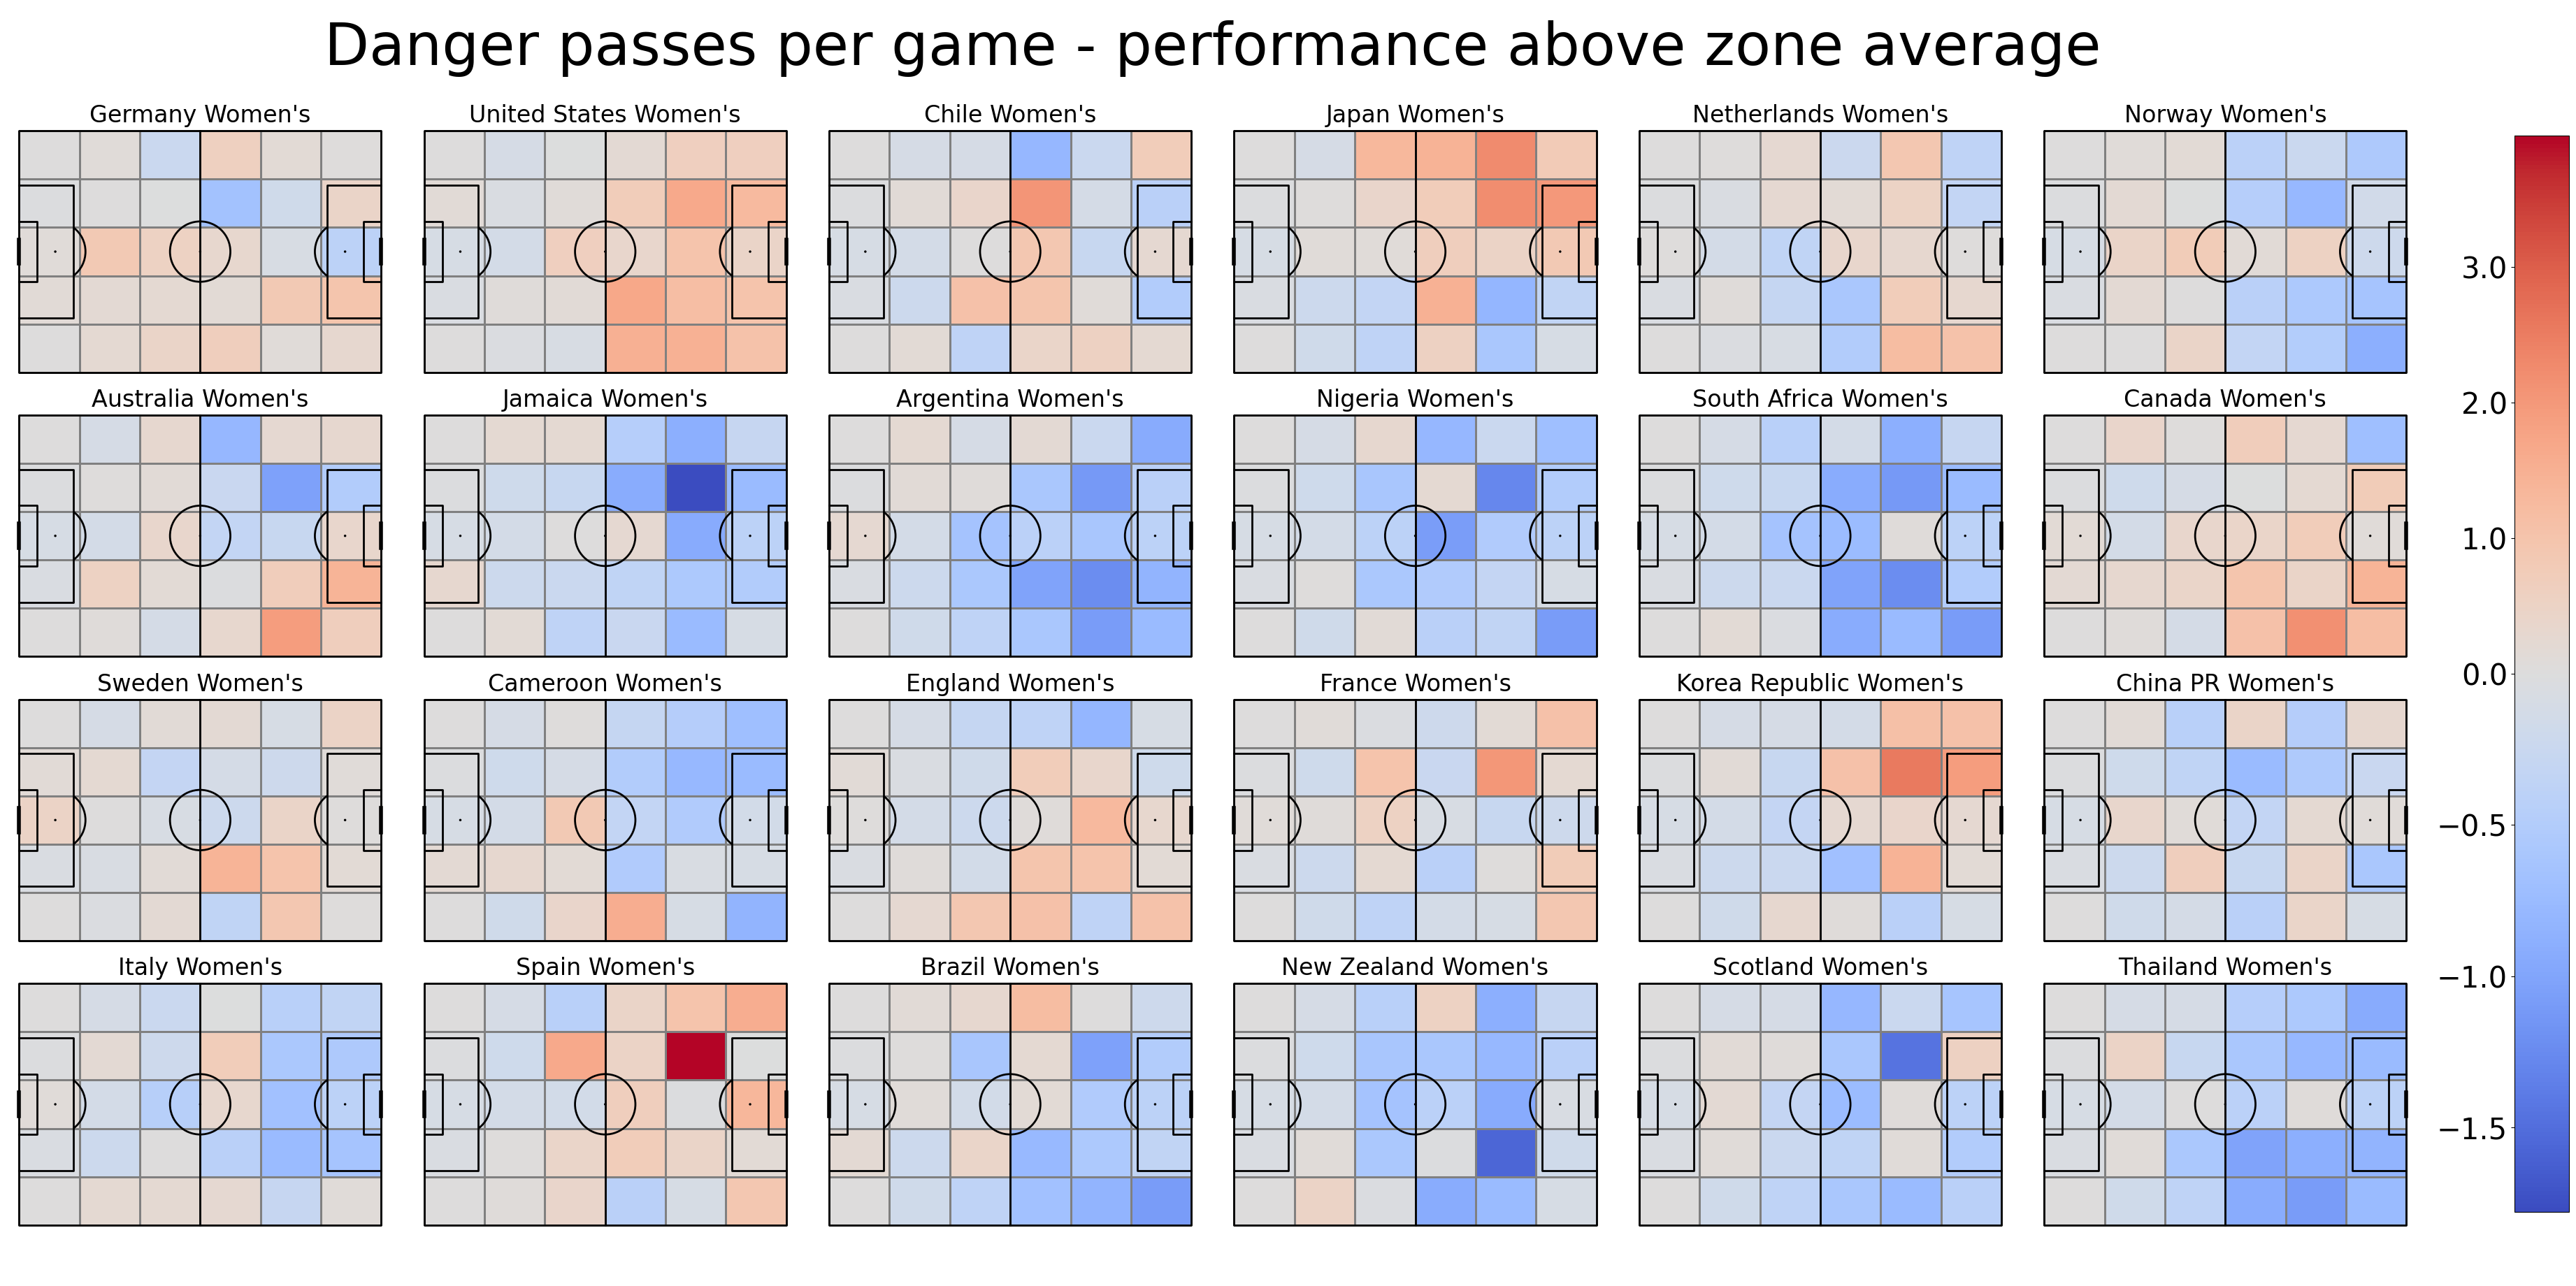

In [40]:
#plot pitch
pitch = Pitch(line_zorder=2, line_color='black')
fig, axs = pitch.grid(ncols = 6, nrows = 4, figheight=20,
                      grid_width=0.88, left=0.025,
                      endnote_height=0.03, endnote_space=0,
                      axis=False,
                      title_space=0.02, title_height=0.06, grid_height=0.8)

# for each team store binned values in a dictionary leveraging previously created grid
hist_dict = {}
for team in teams:
    # get number of games by team
    no_games = len(df_match.query("home_team_name == @team or away_team_name == @team"))
    # get danger passes only by this team
    team_danger_passes = danger_passes_df.query("team_name == @team")
    # number of danger passes in each zone
    bin_statistic = pitch.bin_statistic(team_danger_passes.x, team_danger_passes.y, statistic='count', bins=(6, 5), normalize=False)
    # normalize by number of games
    bin_statistic["statistic"] = bin_statistic["statistic"]/no_games
    # store in dictionary
    hist_dict[team] = bin_statistic

# calculating average per game per team per zone
avg_hist = np.mean(np.array([v["statistic"] for k,v in hist_dict.items()]), axis=0)

# subtracting average to normalize about the average
for team in teams:
    hist_dict[team]["statistic"] = hist_dict[team]["statistic"] - avg_hist

# preparing colormap
vmax = max([np.amax(v["statistic"]) for k,v in hist_dict.items()])
vmin = min([np.amin(v["statistic"]) for k,v in hist_dict.items()])
divnorm = colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)

# for each team plot
for team, ax in zip(teams, axs['pitch'].flat):
    # put team name over the plot
    ax.text(60, -5, team, ha='center', va='center', fontsize=24)
    # plot colormap
    pcm  = pitch.heatmap(hist_dict[team], ax=ax, cmap='coolwarm', norm = divnorm, edgecolor='grey')

# make legend
ax_cbar = fig.add_axes((0.94, 0.093, 0.02, 0.77))
cbar = plt.colorbar(pcm, cax=ax_cbar, ticks=[-1.5, -1, -0.5, 0, 1, 2, 3])
cbar.ax.tick_params(labelsize=30)
ax_cbar.yaxis.set_ticks_position('left')
# add title
axs['title'].text(0.5, 0.5, 'Danger passes per game - performance above zone average', ha='center', va='center', fontsize=60)
plt.show()

## Team Key Performance Indicators
These are metrics which teams leverage to service as headlights for the overall team performance.  They come in a wide varietry and are normally aggregated views across multiple matches.

### Points Moving Average
Investigate Points Moving Average for a club across seasons

### Downloading data
For this task download the data from Football-Data with match scores from the English Premier League since Pep Guardiona began to coach Manchester City. Here, download individual season data, save it in a dataframe and append this dataframe to a list.  Later store the list of dataframes in one big dataframe.

In [41]:
# Instansiate a list for dataframes
dflist = []
# list of all seasons, to use later
seasonst = []
# taking to last year because United hasn't played at the time this code was created
for year in range(16,22,1):
    #create a string with season name
    if year<9:
        yeartext='0'+str(year)+'0'+str(year+1)
        yeartext2='0'+str(year)+'-0'+str(year+1)
    elif year==9:
        yeartext='0910'
        yeartext2='09-10'
    else:
        yeartext=str(year)+str(year+1)
        yeartext2=str(year)+'-'+str(year+1)
    # get data from webpage
    performance_year = pd.read_csv("https://www.football-data.co.uk/mmz4281/"+yeartext+"/E0.csv",delimiter=',')
    # append season name
    seasonst.append(yeartext2)
    # make list of dataframes
    dflist.append(performance_year)
# put dataframes into one big
performance = pd.concat(dflist).reset_index()

### Preparing data
To investigate Pep Guardiola’s City performance against other TOP6 clubs performance in this period, search for each  team's games played and assign number of points earned. Then calculate the 10 game rolling average. Feel free to experiment with window size and check how the diagram is impacted!

In [75]:
# top six teams
teams = ['Man City', 'Liverpool', 'Arsenal', 'Chelsea', 'Tottenham', 'Man United']

# dictionary to store data
team_dfs = dict()
for team in teams:
    # empty dataframe
    team_df = pd.DataFrame(columns = ["Points", "Date", "Game"])
    # get matches by this team
    matches = performance.query("HomeTeam == @team or AwayTeam == @team")
    # auxilliary variable that will be used for plotting
    game = 0
    for i, match in matches.iterrows():
        game +=1
        Date = match.Date
        # when team is away
        if match['AwayTeam'] == team:
            # get goals for both teams
            goalsfor = match['FTAG']
            goalsagainst = match['FTHG']
            # assign 3 points if win, 1 if draw, 0 if lost
            if match['FTR'] == 'A':
                points = 3
            elif match['FTR'] == 'D':
                points = 1
            else:
                points = 0
        else:
            # geat goals for both teams
            goalsfor = match['FTHG']
            goalsagainst = match['FTAG']
            # assign 3 points if win, 1 if draw, 0 if lost
            if match['FTR'] == 'H':
                points = 3
            elif match['FTR'] == 'D':
                points = 1
            else:
                points = 0
        # assign value to dataframe
        team_df.at[i, "Points"] = points
        team_df.at[i, "Game"] = game
        team_df.at[i, "Date"] = Date
    # calculate rolling average
    team_df['PointsRA10'] = team_df['Points'].rolling(window=10, win_type='triang').mean()
    team_df['PointsRA3'] = team_df['Points'].rolling(window=3, win_type='triang').mean()
    # append df
    team_dfs[team] = team_df

### Plot the data
After calculating the rolling average, plot the data. Make sure that the lines below are clear for interpretation.  Remember, the rolling average smooths out the game to game results over a 10 match window.

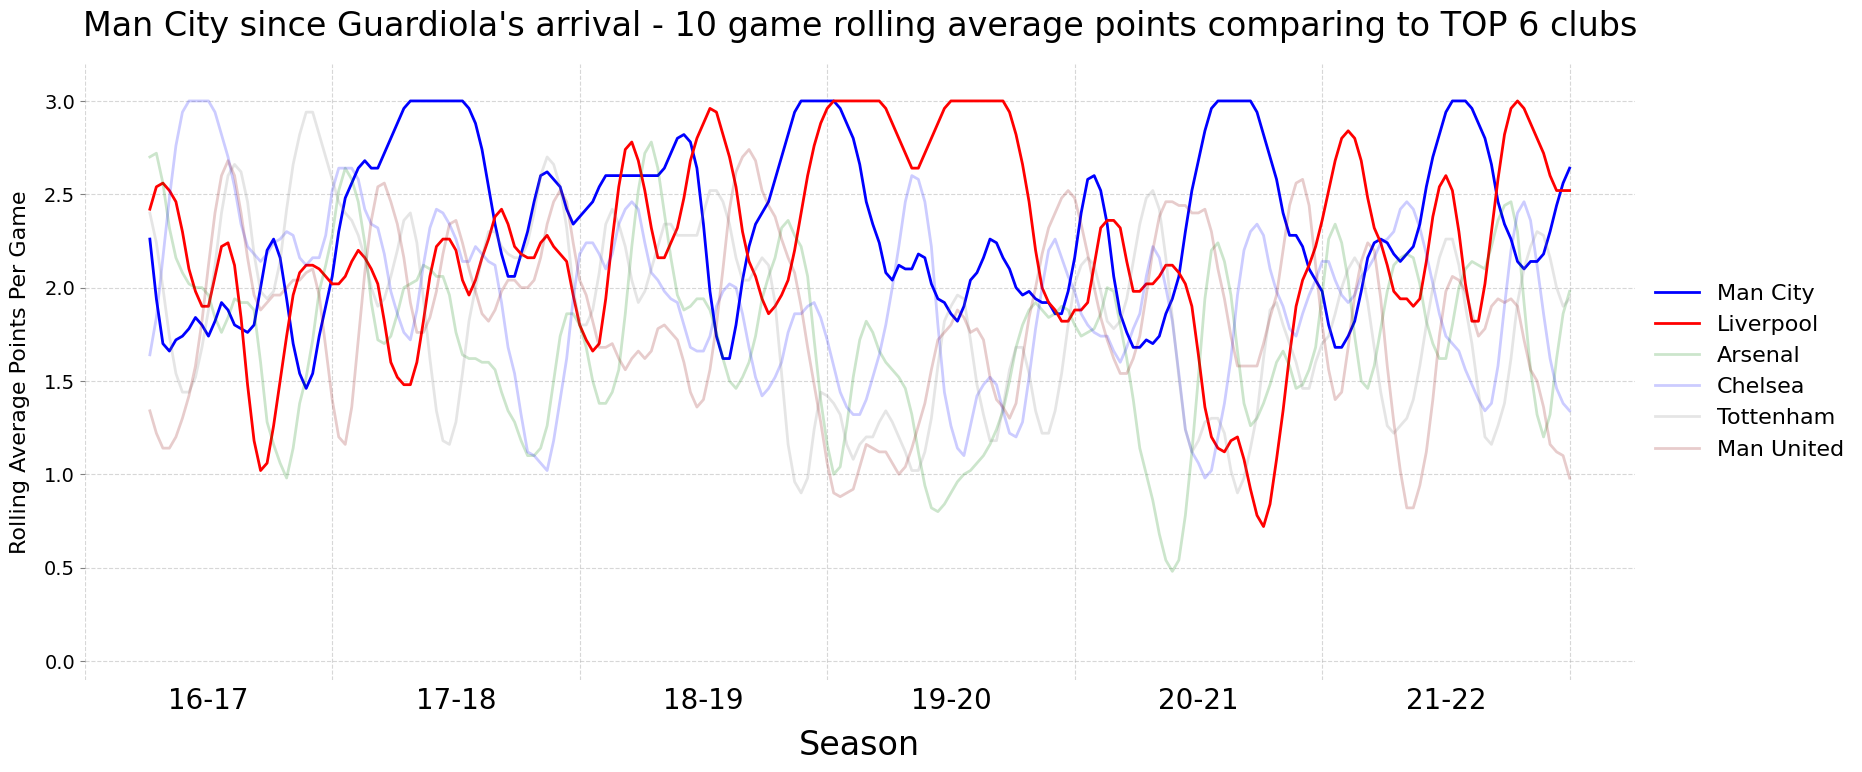

In [43]:
# create plot
fig, ax = plt.subplots(figsize=(20, 8))
# Team color list in the order for the Top6 
colors = ['blue', 'red', 'green', 'blue', 'grey', 'darkred']
# Mancity highlighted more that the others for the plot
alphas = [1, 1, 0.2, 0.2, 0.2, 0.2]
for club, color, alpha in zip(teams, colors, alphas):
    ax.plot(team_dfs[club]['Game'],  team_dfs[club]['PointsRA10'], linewidth=2, 
            linestyle='-',color=color, alpha = alpha, zorder = 2, label = club)

# set title
ax.set_title("Man City since Guardiola's arrival - 10 game rolling average points comparing to TOP 6 clubs", 
             fontsize = 24, pad=20)

# make visible ticks for beginning of each season, remove x axis tick labels, add middle ticks, add season text
ax.set_xticks(np.arange(0, max(team_dfs["Liverpool"]['Game']) + 38, 38))
ax.set_xticklabels([])
ax.set_xticks(np.arange(0, max(team_dfs["Liverpool"]['Game']), 38) + 19, minor=True)
ax.set_xticklabels(seasonst, minor=True)

# set axis limits
ax.set_xlim(0, max(team_dfs["Liverpool"]['Game']) + 10)
ax.set_ylim(-0.1,3.2)

# disable black ticks, but big text xaxis and grey y ticks
ax.tick_params(axis='x', color='white', which='both', labelsize = 20)
ax.tick_params(axis='y', color='grey', labelsize = 14)

# add grid
ax.grid(zorder = 1, linestyle = "--", alpha = 0.5)

#disable spines
ax.spines[['top', 'right', 'left', 'bottom']].set_visible(False)

# add axis labels
ax.set_ylabel('Rolling Average Points Per Game', fontsize = 16,labelpad=10)
ax.set_xlabel('Season', fontsize = 24, labelpad=10)

# make legend
plt.legend(bbox_to_anchor=(1.0, 0.5), loc="center left",fontsize=16, edgecolor='white')
plt.show()

### Challenges
1. Improve the rolling average so it is calculated for each season independently
2. Make this plot for Norwich and account for their relegations.

In [76]:
(performance
 .assign(Date = lambda df_:pd.to_datetime(df_.Date))
 .query('Date.dt.year==2016')
 .Date
#  .info(verbose=True)
 )

0     2016-08-13
1     2016-08-13
2     2016-08-13
3     2016-08-13
4     2016-08-13
         ...    
183   2016-12-31
184   2016-12-31
185   2016-12-31
186   2016-12-31
187   2016-12-31
Name: Date, Length: 188, dtype: datetime64[ns]

In [69]:
seasonst

['16-17', '17-18', '18-19', '19-20', '20-21', '21-22']